# Inferencing output image by using pre-trained Model

In [1]:
import os, torch, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# 체크포인트 경로 및 체크포인트 파일 확인
chk_dir = '/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint'
chk_file = os.path.join(chk_dir, 'model_epoch.pth')

In [4]:
print(os.path.exists(chk_dir))
print(chk_dir)
print(chk_file)

True
/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint
/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint/model_epoch.pth


## Create Dataset and Dataloader for TestModel.

## Create Test Model(with checkpoint file)

In [5]:
# https://pypi.org/project/segmentation-models-pytorch/
!pip install segmentation-models-pytorch
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=09b98ff4bfd72f0b3fc1777b3136fe6253f6c0f2a2f5817e0f225c55ce3d162b
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=d6bebcd38910e2cfd3e6826f437994a29943d85c32ee587387ad2114f3ad248f
  Stored in directory: /root/.cache/pip/w

In [6]:
import segmentation_models_pytorch as smp
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2

In [ ]:
# define model and load pre-trained model.
model = smp.Unet(encoder_name="resnet18", encoder_weights=None, classes=4, activation=None)
dict_model = torch.load(f=chk_file, map_location=torch.device(device))  # keys for dict : 'net', 'optim'

model.load_state_dict(dict_model['net'])
model.eval()

데이터 셋을 만들기 전에 이미지 한 개로 모델 테스트를 해보자.

In [8]:
data_dir = '/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/datasets'
data_test = os.path.join(data_dir, 'test_images')
fnames = os.listdir(data_test)

In [9]:
len(fnames)

5506

In [10]:
input = cv2.imread(os.path.join(data_test, fnames[100]))

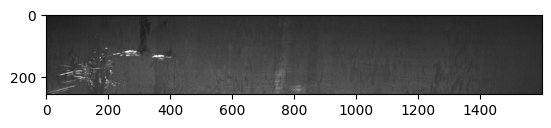

In [11]:
plt.imshow(input)

In [12]:
mean = (0.485, 0.456, 0.406)
std =  (0.229, 0.224, 0.225)
# transform function and apply it.
list_transforms = [Normalize(mean=mean, std=std, p=1), ToTensorV2()]
transforms = Compose(list_transforms)

In [13]:
input_t = transforms(image=input)
input_t = input_t['image']

if input_t.ndim == 3:
  input_t = input_t.unsqueeze(dim=0)
  print(input_t.shape)  # (batch_size, channel, width, height)

torch.Size([1, 3, 256, 1600])


In [41]:
output_t = model(input_t)
output_t = torch.sigmoid(output_t)

In [42]:
# make tensor to numpy
output_n = output_t.detach().cpu().numpy()

In [43]:
output_n =output_n.transpose(0,2,3,1)
output_n.shape

(1, 256, 1600, 4)

In [51]:
type(output_n)

numpy.ndarray

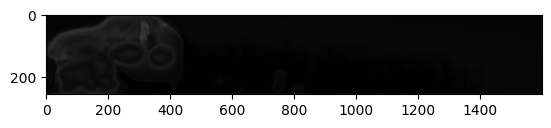

In [55]:
plt.imshow(output_n[0][:,:,0], cmap='gray')

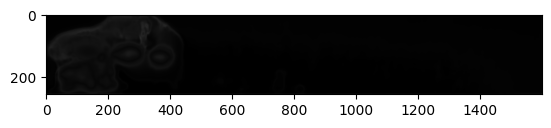

In [56]:
plt.imshow(output_n[0][:,:,1], cmap='gray')

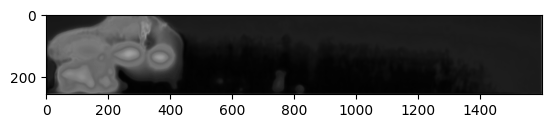

In [57]:
plt.imshow(output_n[0][:,:,2], cmap='gray')

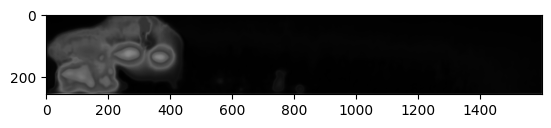

In [58]:
plt.imshow(output_n[0][:,:,3], cmap='gray')

(array([1.264669e+06, 2.609030e+05, 3.604400e+04, 1.231600e+04,
        5.238300e+04, 1.102800e+04, 1.035000e+03, 2.000000e+01,
        0.000000e+00, 2.000000e+00]),
 array([4.85413802e-05, 1.48772169e-02, 2.97058914e-02, 4.45345677e-02,
        5.93632422e-02, 7.41919205e-02, 8.90205950e-02, 1.03849269e-01,
        1.18677944e-01, 1.33506611e-01, 1.48335293e-01]),
 <BarContainer object of 10 artists>)

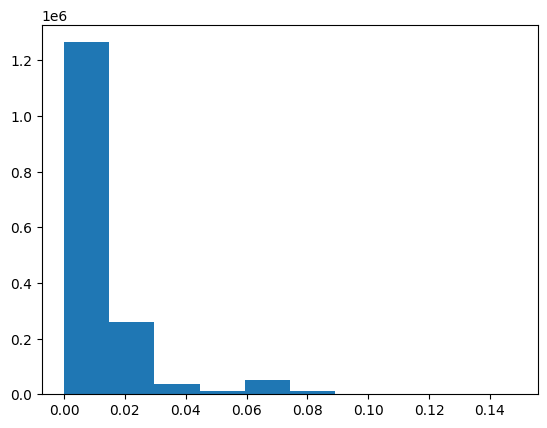

In [60]:
plt.hist(output_n[0].ravel())